In [126]:
#importuje wszytskie potrzebne biblioteki w tym biblioteke kwant
import kwant
import numpy as np
import types
import matplotlib.pyplot as plt
      
    
#Obliczenia prowadze sa w jednostkach atomowych e=h=me=1. Tutaj definiuje wspolczynniki konwersji.
def eV2au(energy): #eV -> j.a
    return energy*0.03674932587122423
def nm2au(length): #nm -> j.a
    return length*18.89726133921252
def T2au(length):  #T -> j.a
    return length*4.254382E-6


In [127]:

t = eV2au(3)
sin_30 = np.sin(30*np.pi/180)
cos_30 = np.cos(30*np.pi/180)

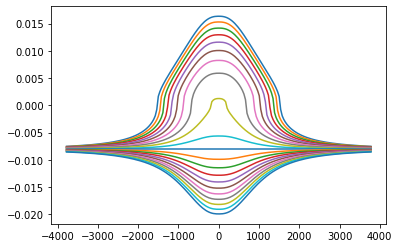

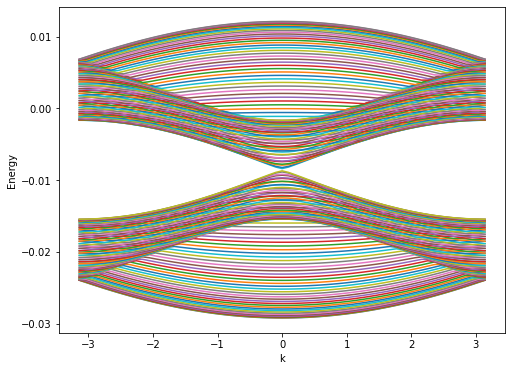

In [128]:
def make_system(x_min = -200, x_max = 200, y_min = -79.9, y_max = 79.9, w = 46, V_bg = 50, V_tg = 10, B = 0, sf = 16):
    y_min = nm2au(y_min)
    y_max = nm2au(y_max)
    x_min = nm2au(x_min)
    x_max = nm2au(x_max)
    t0 = t/sf
    t_si = 3/sf  #Potrzebujemy tych wartości w SI to obliczenia n(x)
    a_cc_si = 0.25e-9*sf/np.sqrt(3)
    B = T2au(B)
    a0 = nm2au (0.25) * sf
    a_cc = a0/np.sqrt(3)
    
    C_bg = 7.2402392330e14 
    C_tg = 12.8*C_bg
    w = nm2au(w)


    sys_gr1 = kwant.Builder()

    graphene = kwant.lattice.general([(0 , a0 ) , ( cos_30 *a0 , sin_30 * a0 )],
                                         [(0 , 0) , ( a_cc , 0) ], norbs =1)

    lat_A, lat_B = graphene.sublattices

    def rect(pos):
        x, y = pos
        if x_min<=x<=x_max and y_min<=y<=y_max:
            return True
        else:
            return False

    def lead_shape(pos):
        x, y = pos
        return (y_min <= y <= y_max)
    
    def calc_n_x(x):
        return (C_tg*V_tg)/(1 + np.abs(x/w)**(2.5)) + V_bg*C_bg

    def potential(site):
        x, y = site.pos
        n_x = calc_n_x(x)
        return eV2au(-np.sign(n_x) * (3*t_si*a_cc_si)/(2) * np.sqrt(np.pi * np.abs(n_x)))
    
    V_tg_table = np.linspace(-20, 20, 21)
    for V_tg in V_tg_table:
        x_table = np.linspace(x_min, x_max, 200)
        V_table = np.zeros(200)
        for i, x in enumerate(x_table):
            V_table[i] = eV2au(-np.sign(calc_n_x(x)) * (3*t_si*a_cc_si)/(2) * np.sqrt(np.pi * np.abs(calc_n_x(x))))
        plt.plot(x_table, V_table)
    plt.show()

    def nn_hopping(site1, site2):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        flux = -B*(y1+y2)*(x2 -x1)/2
        return -t0*np.exp(1j*flux)

    sys_gr1[graphene.shape(rect, (0,0))] = potential
    sys_gr1[graphene.neighbors()] = nn_hopping

    syml = kwant.TranslationalSymmetry([-np.sqrt(3)*a0, 0])
    symr = kwant.TranslationalSymmetry([np.sqrt(3)*a0, 0])
    # syml.add_site_family(graphene.sublattices[0], other_vectors=[(1, -1)])
    # syml.add_site_family(graphene.sublattices[1], other_vectors=[(1, -1)])

    leadl = kwant.Builder(syml) 
    leadl[graphene.shape(lead_shape, (0, 0))] = eV2au(-np.sign(calc_n_x(x_min)) * (3*t_si*a_cc_si)/(2) * np.sqrt(np.pi * np.abs(calc_n_x(x_min))))
    leadl[graphene.neighbors()] = nn_hopping

    leadr = kwant.Builder(symr) 
    leadr[graphene.shape(lead_shape, (0, 0))] = eV2au(-np.sign(calc_n_x(x_max)) * (3*t_si*a_cc_si)/(2) * np.sqrt(np.pi * np.abs(calc_n_x(x_max))))
    leadr[graphene.neighbors()] = nn_hopping

    sys_gr1.attach_lead(leadl)
    sys_gr1.attach_lead(leadr)
    sysf = sys_gr1.finalized()
    kwant.plot(sys_gr1, site_color = potential, site_lw=0.1, site_size=0.5, cmap ="gist_heat_r", file = "potential_map.png")
    return sysf

sysf = make_system()
kwant.plotter.bands(sysf.leads[0], show=True,  fig_size = (8,6));




(-0.02, 0.02)

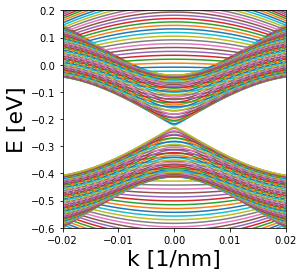

In [116]:
def disperssion(nr_lead, k_max, nk):
    sys=make_system()
    momenta = np.linspace(-k_max*dx,k_max*dx,nk)
    bands=kwant.physics.Bands(sys.leads[nr_lead])
    energies=[bands(k) for k in momenta]
    return (momenta/dx), energies


sf = 16
a0 = nm2au(0.25)*sf
dx=np.sqrt(3)*a0
momenta, energies = disperssion(0, np.pi/dx, 400)
plt.figure(figsize=(4,4))
plt.plot(momenta, np.asarray(energies)/eV2au(1.0)) 
plt.xlabel("k [1/nm]",fontsize=22)
plt.ylabel("E [eV]",fontsize=22)
plt.ylim(-0.6, 0.2)
plt.xlim(-0.02, 0.02)

In [125]:
V_tg_min = -10
V_tg_max = -3.5
V_tg_table = np.linspace(V_tg_min, V_tg_max, 1000)
E = 0

B_table = np.arange(0, 0.8, 0.2)

plt.figure(figsize=(8, 6))

for B in B_table:
    cond_table = [] 
    print(B_table)

    for V_tg in V_tg_table:
        sys = make_system(V_tg=V_tg, B=B)
        smatrix = kwant.smatrix(sys, E)
        cond_table.append(smatrix.transmission(1, 0))
        print(V_tg)

    plt.plot(V_tg_table, cond_table, label=f"B = {B:.3f}")

plt.xlabel(r"$V_{tg} [V]$")
plt.ylabel(r"$G \; [2e^2/h]$")
plt.title("Conductance vs V_tg for different B")
plt.legend()
plt.tight_layout()
plt.savefig("conductance.png", dpi=200)
plt.show()


KOLEJNE B
[0.  0.2 0.4 0.6]
-10.0
-9.993493493493494


KeyboardInterrupt: 

<Figure size 576x432 with 0 Axes>